#**Credit Card Fraud Detection**
"The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions."

<br>

Use of data :
[Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)



In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
#Necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


##**Loading Data**##

In [45]:
#archive.zip (Compressed zip file of creditcard.csv)

data = pd.read_csv("archive.zip")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [46]:
data.shape

(284807, 31)

In [47]:
#for simplicity
data = data.head(50000)
data.shape

(50000, 31)

In [48]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [49]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [50]:
#Check for null values
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [51]:
#Group by class for each column

data.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852
1,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148


##**Feature Engineering**##


In [52]:
#Drop Time column (no need)
data = data.drop(['Time'], axis = 1)

In [53]:
#scale amount to be between -1 to 1
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [54]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [55]:
#Split training data and test data

X_train, X_test = train_test_split(data, test_size = 0.2)
X_train = X_train.drop(['Class'], axis = 1) #No need of label for training data

y_test = X_test['Class'] #Only the labels
X_test = X_test.drop(['Class'], axis = 1) #No need of label for x test data

X_train = X_train.values
X_test = X_test.values

In [56]:
X_train.shape

(40000, 29)

In [57]:
X_test.shape

(10000, 29)

##**Autoencoder Model**##

Dense autoencoder model with four layers

In [58]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [59]:
#Model construction
model = Sequential()
model.add(Dense(encoding_dim, activation="tanh", input_shape = (input_dim, )))
model.add(Dense((encoding_dim // 2), activation = "relu"))
model.add(Dense((encoding_dim // 2), activation = "tanh"))
model.add(Dense(input_dim, activation = "relu"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 14)                420       
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_16 (Dense)             (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


##**Model Training**##

In [60]:
epochs = 40
batch_size = 32

In [61]:
#Adam optimizer, Loss function = MSE
model.compile(optimizer="adam", loss="mean_squared_error", metrics = ['acc'])

history = model.fit(X_train, X_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (X_test, X_test),
                    verbose = 1)

autoencoder = model


Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 2s 53us/step - loss: 1.0905 - acc: 0.3498 - val_loss: 0.8794 - val_acc: 0.4807
Epoch 2/40
40000/40000 [==============================] - 2s 43us/step - loss: 0.9701 - acc: 0.5278 - val_loss: 0.8101 - val_acc: 0.5832
Epoch 3/40
40000/40000 [==============================] - 2s 43us/step - loss: 0.9285 - acc: 0.5889 - val_loss: 0.7852 - val_acc: 0.6059
Epoch 4/40
40000/40000 [==============================] - 2s 44us/step - loss: 0.9075 - acc: 0.6056 - val_loss: 0.7685 - val_acc: 0.6209
Epoch 5/40
40000/40000 [==============================] - 2s 45us/step - loss: 0.8923 - acc: 0.6304 - val_loss: 0.7556 - val_acc: 0.6517
Epoch 6/40
40000/40000 [==============================] - 2s 43us/step - loss: 0.8803 - acc: 0.6588 - val_loss: 0.7461 - val_acc: 0.6750
Epoch 7/40
40000/40000 [==============================] - 2s 44us/step - loss: 0.8722 - acc: 0.6752 - val_loss: 0.7412 - val_ac

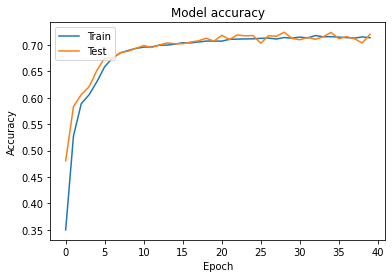

In [62]:
#Data result visualization

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc="upper left")
plt.show()

##**Prediction**##

In [64]:
predict = autoencoder.predict(X_test)
MSE = np.mean(np.power(X_test - predict, 2), axis = 1) #Mean Square Error
error_df = pd.DataFrame({'reconstruction_error': MSE, 'true_label': y_test})

In [65]:
error_df.head()

,reconstruction_error,true_label
32539,0.388511,0
29254,0.447360,0
46788,0.313124,0
34273,0.102745,0
43249,1.562145,0


In [67]:
error_df.groupby(['true_label']).count()

,reconstruction_error
true_label,
0,9982
1,18


##**Reconstruction Error**##

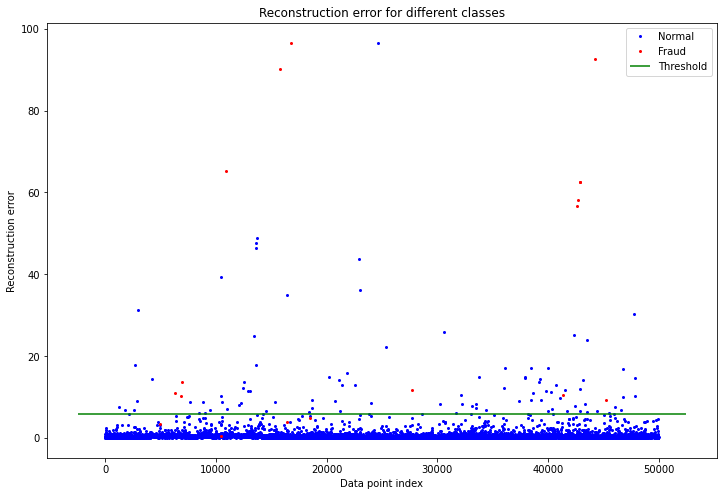

In [71]:
threshold = 6.0

groups = error_df.groupby('true_label')
fig, ax = plt.subplots(figsize = (12, 8))


for name, group in groups:
  ax.plot(group.index, group.reconstruction_error, marker='o', ms = 2.0, linestyle='',
          label = "Fraud" if name == 1 else "Normal",
          color = "red" if name == 1 else "blue" )

ax.hlines(threshold, 
          ax.get_xlim()[0],
          ax.get_xlim()[1],
          colors = "green", zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

##**Data analysis**##

In [73]:
#Differentiate by class label
normal = error_df[error_df.true_label == 0]
fraud = error_df[error_df.true_label == 1]

print(f"Normal transactions: {len(normal)}, fraud transaction: {len(fraud)}")

Normal transactions: 9982, fraud transaction: 18


In [75]:
T_pos = len(fraud[fraud.reconstruction_error >= threshold])
F_pos = len(normal[normal.reconstruction_error >= threshold])

T_neg = len(normal[normal.reconstruction_error < threshold])
F_neg = len(fraud[fraud.reconstruction_error < threshold])

print(f"True positives : {T_pos}, true negatives : {T_neg}")
print(f"False positives : {F_pos}, false negatives : {F_neg}")

True positives : 14, true negatives : 9888
False positives : 94, false negatives : 4
